GJ4102: G140L spectra redone by STScI, G140M specta need re-exracting

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/'
stsci_path = '{}16701_07/data/'.format(path) #some data was redone by stsci.
st_x1ds = glob.glob('{}*x1d.fits'.format(stsci_path))
st_x1ds

['/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07020_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07030_x1d.fits']

/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07010_x1d.fits
G140L
82.32629


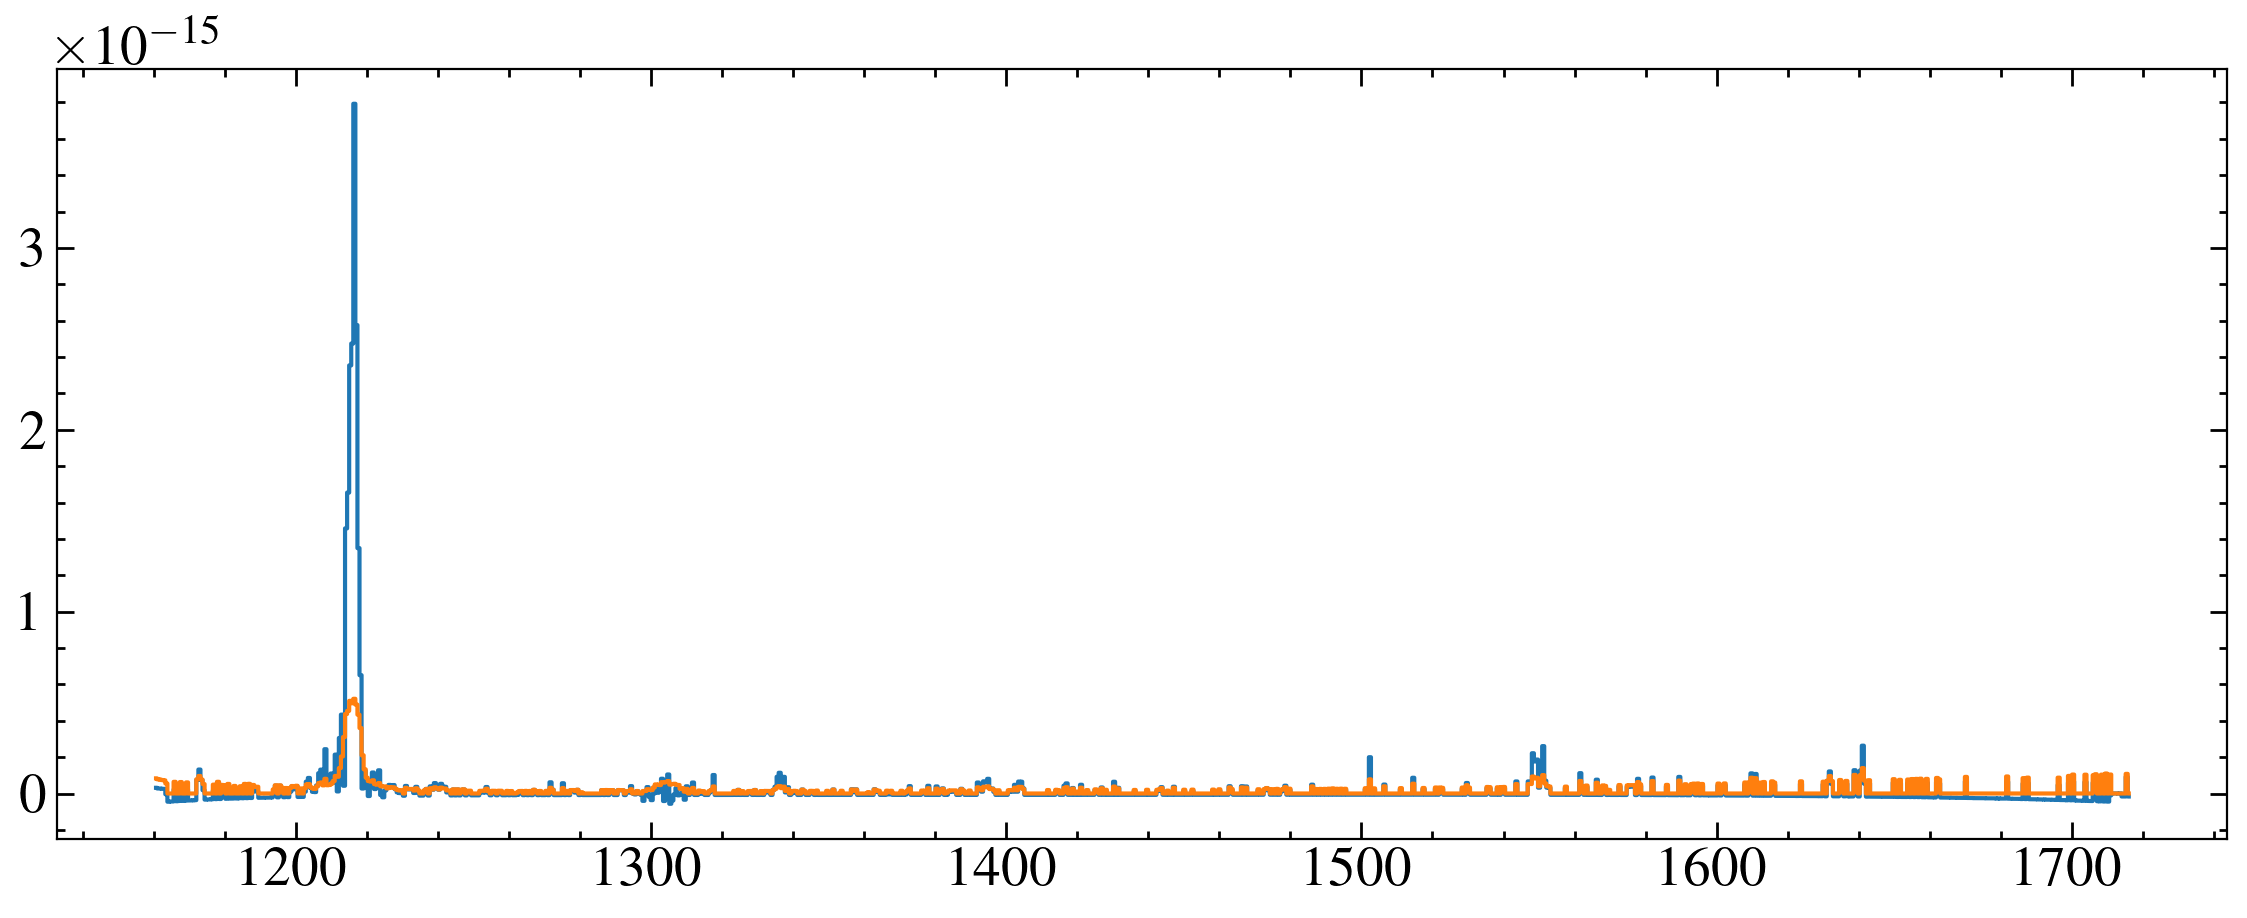

/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07020_x1d.fits
G140L
82.42636


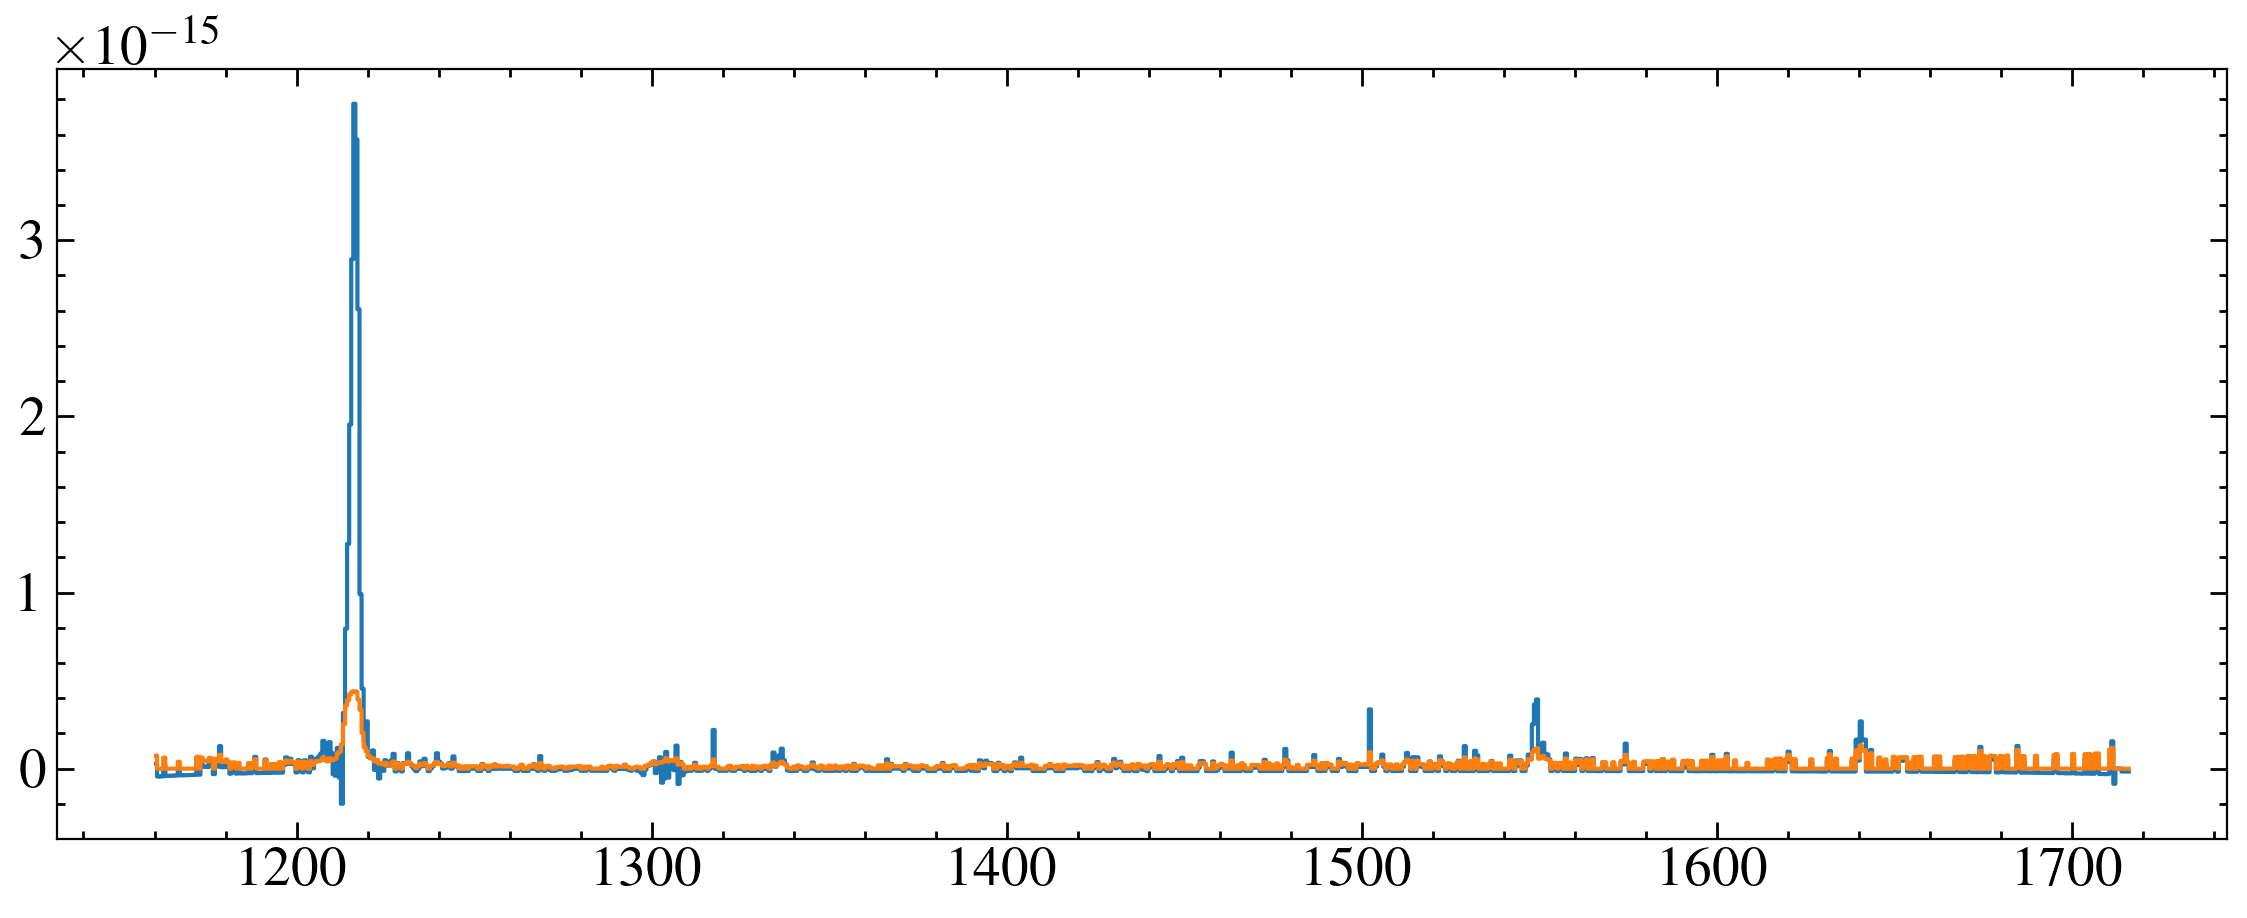

/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07030_x1d.fits
G140L
83.107735


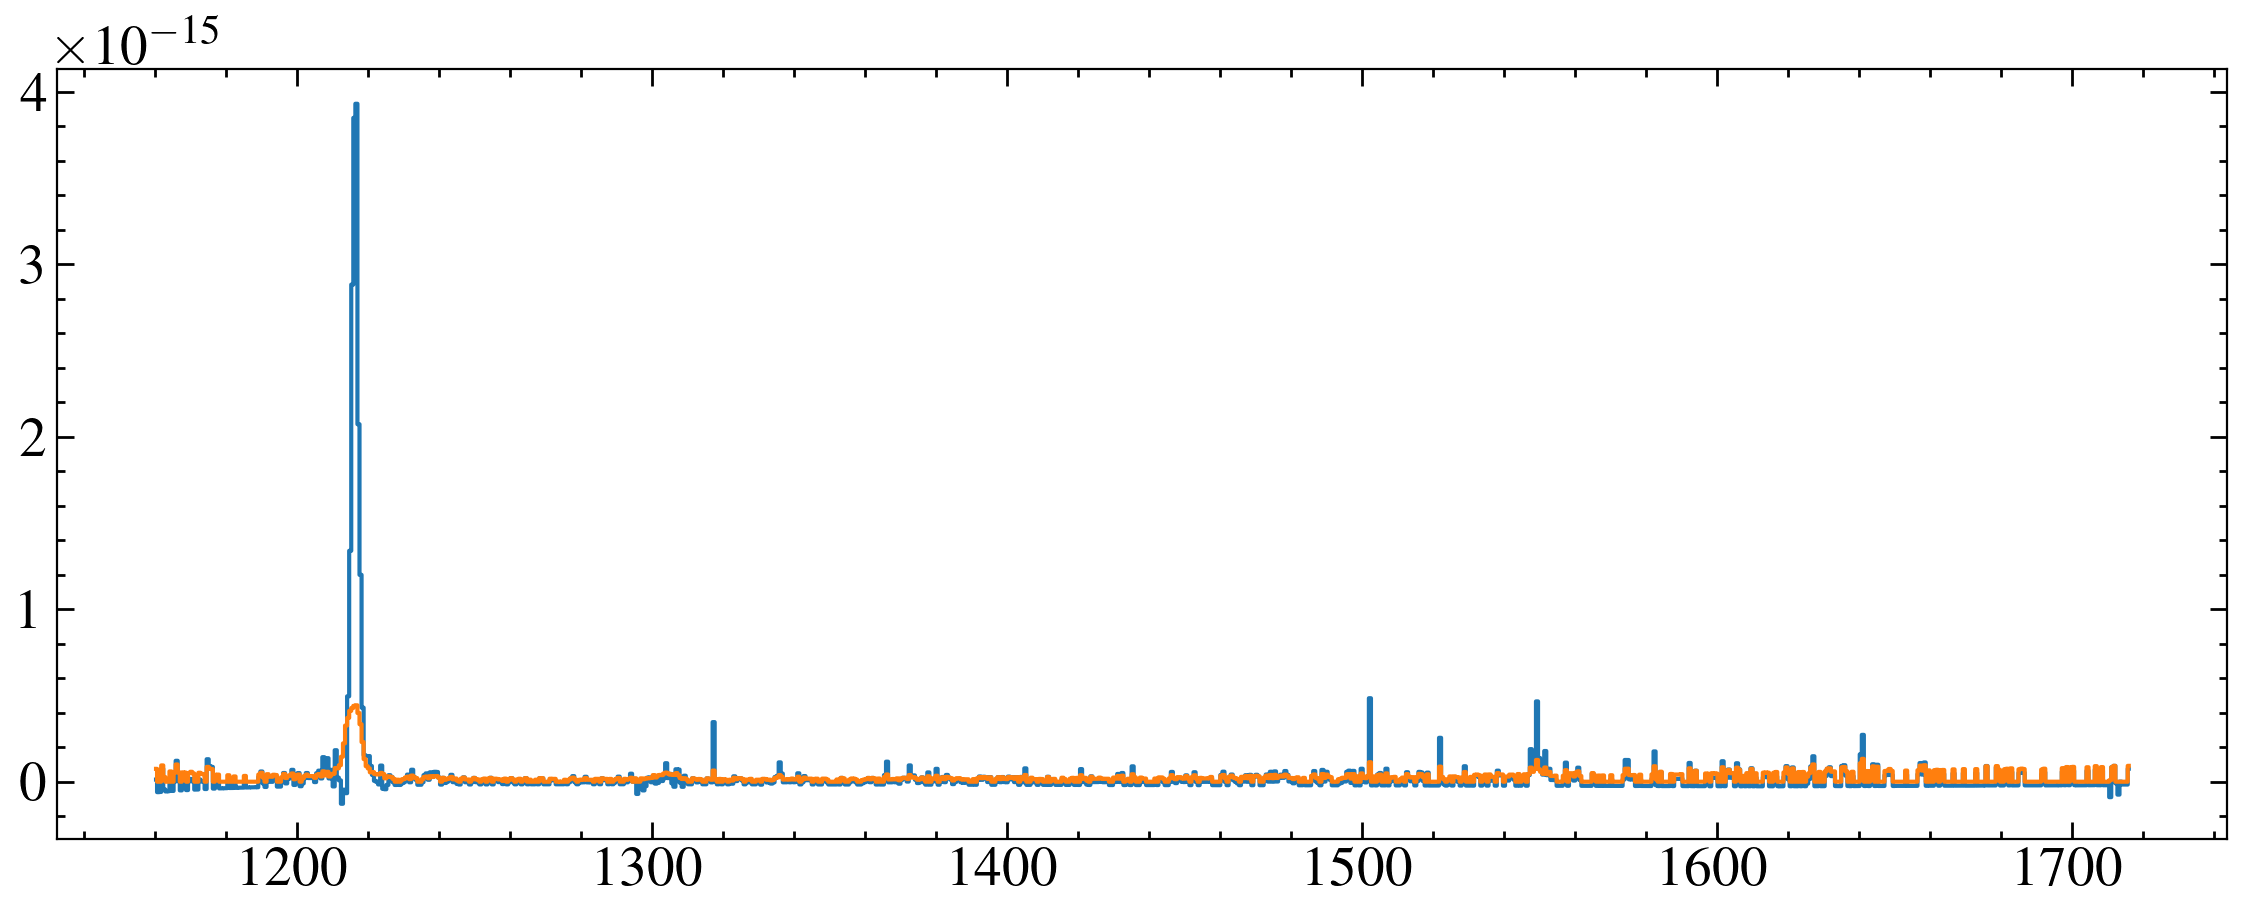

In [3]:
for x in st_x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    data = fits.getdata(x, 1)[0]
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating in ['G140M', 'G140L']:
        mask = (w > 1160)
        
        # plt.ylim(-1e-16, 1e-16)
        # plt.axhline(0, ls='--', c='0.5')
    # if grating =='G230L':
    #     mask = (w > 1700)
    # if grating =='G430L':
    #     mask = (w > 3000)
    
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
    plt.show()
    

In [4]:
import stistools
os.environ['oref'] = path

/home/david/micromamba/envs/stenv/lib/python3.12/site-packages/stsci/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/micromamba/envs/stenv/lib/python3.12/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/micromamba/envs/stenv/lib/python3.12/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


In [5]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid
    
def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

In [6]:
roots = ['oeoo08010', 'oeoo08020', 'oeoo08030']


In [7]:
# xs = [405, 408, 410]
# ys = [157, 157, 158]

# for i, root in  enumerate(roots):
#     flt = '{}/{}_flt.fits'.format(path, root)
#     SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
#     grating = fits.getheader(flt,0)['OPT_ELEM']
#     cenwave = fits.getheader(flt,0)['CENWAVE']
#     tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
#     rootname = fits.getheader(flt)['ROOTNAME'] 
#     outname = 'reextractions/gj4102/{}_new_x1d.fits'.format(rootname)
#     if os.path.exists(outname):
#         os.remove(outname)
#     a2center = get_a2center(xs[i],ys[i], tracegrid)
#     print(root)
#     print(a2center)
#     # a2center = 375
#     stistools.x1d.x1d(flt, output = outname, trailer='reextractions/gj4102/{}_new.trl'.format(rootname), a2center=a2center,
#                       maxsrch=5, bk1offst=-30, bk2offst=30,
#                       bk1size=5, bk2size=5)
#     # print(fits.getdata('reextractions/gj4102/{}_new_x1d.fits'.format(rootname),1)['A2CENTER'])
    
# new_x1ds = glob.glob('reextractions/gj4102/*new_x1d.fits')
# for x in new_x1ds:
#     print(x)
#     grating = fits.getheader(x, 0)['OPT_ELEM'] 
#     print(grating)
#     data = fits.getdata(x, 1)[0]
#     print(data['A2Center'])
#     w, f, e, dq= data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
#     if grating in ['G140M', 'G140L']:
#         mask = (w > 1160) #& (w < 1210) | (w > 1220)

    
#     w, f, e = w[mask], f[mask], e[mask]

#     plt.step(w, f, where='mid')
#     plt.step(w, e, where='mid')
#     plt.ylim(-0.5e-14,3e-14 )
#     # plt.show()
    


In [8]:
new_x1ds = glob.glob('reextractions/gj4102/*new_x1d.fits')
new_x1ds

['reextractions/gj4102/oeoo09010_new_x1d.fits',
 'reextractions/gj4102/oeoo09020_new_x1d.fits',
 'reextractions/gj4102/oeoo09030_new_x1d.fits',
 'reextractions/gj4102/oeoo09040_new_x1d.fits',
 'reextractions/gj4102/oeoo08020_new_x1d.fits',
 'reextractions/gj4102/oeoo08030_new_x1d.fits',
 'reextractions/gj4102/oeoo08010_new_x1d.fits']

In [9]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**0.5
    return flux,error

In [10]:
x1ds = np.hstack((new_x1ds, st_x1ds))
x1ds

array(['reextractions/gj4102/oeoo09010_new_x1d.fits',
       'reextractions/gj4102/oeoo09020_new_x1d.fits',
       'reextractions/gj4102/oeoo09030_new_x1d.fits',
       'reextractions/gj4102/oeoo09040_new_x1d.fits',
       'reextractions/gj4102/oeoo08020_new_x1d.fits',
       'reextractions/gj4102/oeoo08030_new_x1d.fits',
       'reextractions/gj4102/oeoo08010_new_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07030_x1d.fits'],
      dtype='<U80')

In [11]:


plt.figure(figsize=(12, 5))

f_nuv = []
e_nuv = []
f_fuv = []
e_fuv = []
f_lya = []
e_lya = []

n=0
o=0
p=0
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G230L':
        mask = (w > 1800) & (w <3130)
        w, f, e = w[mask], f[mask], e[mask]
        if n == 0:
            w_nuv = w
            f_nuv.append(f)
            e_nuv.append(e)
        else:
            f_nuv.append(interp1d(w, f, fill_value='extrapolate')(w_nuv))
            e_nuv.append(interp1d(w, e, fill_value='extrapolate')(w_nuv))            
        n +=1
    if grating == 'G140L':
        mask = (w > 1160)# & (w <1700)
        w, f, e = w[mask], f[mask], e[mask]
        if o == 0:
            w_fuv = w
            f_fuv.append(f)
            e_fuv.append(e)
        else:
            f_fuv.append(interp1d(w, f, fill_value='extrapolate')(w_fuv))
            e_fuv.append(interp1d(w, e, fill_value='extrapolate')(w_fuv))            
        o +=1
    if grating == 'G140M':
        # mask = (w > 1160) & (w <1700)
        # w, f, e = w[mask], f[mask], e[mask]
        if p == 0:
            w_lya = w
            f_lya.append(f)
            e_lya.append(e)
        else:
            f_lya.append(interp1d(w, f, fill_value='extrapolate')(w_lya))
            e_lya.append(interp1d(w, e, fill_value='extrapolate')(w_lya))            
        p +=1
    if grating == 'G430L':
        mask = (w > 3050) & (w <5520)
        w_opt, f_opt, e_opt = w[mask], f[mask], e[mask]
        
# f_nuv, e_nuv = spectra_adder(np.array(f_nuv), np.array(e_nuv), scale_correct=True)
f_fuv, e_fuv = spectra_adder(np.array(f_fuv), np.array(e_fuv), scale_correct=True)
f_lya, e_lya = spectra_adder(np.array(f_lya), np.array(e_lya), scale_correct=True)

plt.step(w_fuv, f_fuv, label='G140L')
# plt.step(w_nuv, f_nuv, label='G230L')
plt.step(w_lya, f_lya, label='G140M')
# plt.step(w_opt, f_opt, label='G430L', zorder=-1)

plt.yscale('log')
# plt.xscale('log')
plt.ylim(1.1e-18)
# plt.xlim(1060, 5520)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(frameon=True, loc=4)
plt.title('GJ4102')
plt.tight_layout()

<>:67: SyntaxWarning: invalid escape sequence '\A'
<>:68: SyntaxWarning: invalid escape sequence '\A'
<>:67: SyntaxWarning: invalid escape sequence '\A'
<>:68: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_259031/2642720501.py:67: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('Wavelength (\AA)')
/tmp/ipykernel_259031/2642720501.py:68: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')


In [12]:
fig, ax=plt.subplots(figsize=(10,5))

plt.step(w_lya, f_lya, label='G140M',where='mid')

plt.step(w_fuv, f_fuv, label='G140L', where='mid')

plt.xlim(1209, 1221)
plt.ylim(-0.3e-14, 2.1e-14)
ax.legend(frameon=True)

Got new G140M, G230L and G430L data. F/NUV data need rextracting.  oeoo09050= G430L, looks fine

In [13]:
npath = '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/may_obs/'
flts = glob.glob('{}*flt.fits'.format(npath))
# flts
g430l=  glob.glob('{}*sx1.fits'.format(npath))
g430l

['/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/may_obs/oeoo09050_sx1.fits']

In [14]:
os.environ['oref'] = npath

In [15]:
roots = ['oeoo09010', 'oeoo09020','oeoo09030','oeoo09040']

# xs = [405, 408, 410]
ys = [526, 526, 136,136]



for i, root in  enumerate(roots):
    flt = '{}/{}_flt.fits'.format(npath, root)
    SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
    grating = fits.getheader(flt,0)['OPT_ELEM']
    cenwave = fits.getheader(flt,0)['CENWAVE']
    # tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
    rootname = fits.getheader(flt)['ROOTNAME'] 
    outname = 'reextractions/gj4102/{}_new_x1d.fits'.format(rootname)
    if os.path.exists(outname):
        os.remove(outname)
    # a2center = get_a2center(xs[i],ys[i], tracegrid)
    # print(root)
    # print(a2center)
    a2center = ys[i]
    stistools.x1d.x1d(flt, output = outname, trailer='reextractions/gj4102/{}_new.trl'.format(rootname), a2center=a2center,
                      maxsrch=10, bk1offst=-30, bk2offst=30,
                      bk1size=5, bk2size=5)
    # print(fits.getdata('reextractions/gj4102/{}_new_x1d.fits'.format(rootname),1)['A2CENTER'])
    
new_x1ds = glob.glob('reextractions/gj4102/*new_x1d.fits')
for x in new_x1ds:
    # print(x)
    root = fits.getheader(x, 0)['ROOTNAME']
    if root in roots:

        print(root)
        grating = fits.getheader(x, 0)['OPT_ELEM'] 
        print(grating)
        data = fits.getdata(x, 1)[0]
        print(data['A2Center'])
        w, f, e, dq= data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
        if grating in ['G140M', 'G140L']:
            mask = (w > 1160) #& (w < 1210) | (w > 1220)


        w, f, e = w[mask], f[mask], e[mask]

        plt.step(w, f, where='mid')
        plt.step(w, e, where='mid')
        # plt.ylim(-0.5e-14,3e-14 )
        plt.show()



oeoo09010
G230L
532.8642
oeoo09020
G230L
533.0787
oeoo09030
G140L
138.77849
oeoo09040
G140L
137.19199


/tmp/ipykernel_259031/3675578645.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [16]:
x1ds = np.hstack((new_x1ds, st_x1ds, g430l))
x1ds

array(['reextractions/gj4102/oeoo09010_new_x1d.fits',
       'reextractions/gj4102/oeoo09020_new_x1d.fits',
       'reextractions/gj4102/oeoo09030_new_x1d.fits',
       'reextractions/gj4102/oeoo09040_new_x1d.fits',
       'reextractions/gj4102/oeoo08020_new_x1d.fits',
       'reextractions/gj4102/oeoo08030_new_x1d.fits',
       'reextractions/gj4102/oeoo08010_new_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07030_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/may_obs/oeoo09050_sx1.fits'],
      dtype='<U80')

Need to do the fancy person errors thing for the fuv

In [17]:
import astropy.stats as stats
def make_person_errors(data, hdr):
    """
    Recalculates the error array using a pearson confidence interval - this corrects for the pipeline producing errors with zero
    """
    sensitivity = data['FLUX'] / data['NET'] #sensitivity curve of the spectrum 
    counts = data['GROSS'] * hdr['EXPTIME'] #total counts obtained in each wavelength bin during the exposure
    ci = stats.poisson_conf_interval(counts, interval='pearson') #pearson confidence interval
    ci = np.nan_to_num(ci, nan=0.0)
    count_errors = np.mean(abs(ci -counts), axis = 0) #average the upper and lower errorbars
    new_error = count_errors * sensitivity/hdr['EXPTIME'] #convert error to flux units    
    return new_error


In [18]:


plt.figure(figsize=(12, 5))

f_nuv = []
e_nuv = []
f_fuv = []
e_fuv = []
f_lya = []
e_lya = []

n=0
o=0
p=0
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    hdr = fits.getheader(x, 0)
    hdr1 = fits.getheader(x, 1)
    grating = hdr['OPT_ELEM']
    if grating == 'G230L':
        mask = (w > 1800) & (w <3130)
        w, f, e = w[mask], f[mask], e[mask]
        if n == 0:
            w_nuv = w
            f_nuv.append(f)
            e_nuv.append(e)
        else:
            f_nuv.append(interp1d(w, f, fill_value='extrapolate')(w_nuv))
            e_nuv.append(interp1d(w, e, fill_value='extrapolate')(w_nuv))            
        n +=1
    if grating == 'G140L':
        mask = (w > 1160)# & (w <1700)
        e = make_person_errors(data, hdr1)
        w, f, e = w[mask], f[mask], e[mask]
        if o == 0:
            w_fuv = w
            f_fuv.append(f)
            e_fuv.append(e)
        else:
            f_fuv.append(interp1d(w, f, fill_value='extrapolate')(w_fuv))
            e_fuv.append(interp1d(w, e, fill_value='extrapolate')(w_fuv))            
        o +=1
    if grating == 'G140M':
        # mask = (w > 1160) & (w <1700)
        # w, f, e = w[mask], f[mask], e[mask]
        e = make_person_errors(data, hdr1)
        if p == 0:
            w_lya = w
            f_lya.append(f)
            e_lya.append(e)
        else:
            f_lya.append(interp1d(w, f, fill_value='extrapolate')(w_lya))
            e_lya.append(interp1d(w, e, fill_value='extrapolate')(w_lya))            
        p +=1
    if grating == 'G430L':
        mask = (w > 3050) & (w <5520)
        w_opt, f_opt, e_opt = w[mask], f[mask], e[mask]
        
f_nuv, e_nuv = spectra_adder(np.array(f_nuv), np.array(e_nuv), scale_correct=True)
f_fuv, e_fuv = spectra_adder(np.array(f_fuv), np.array(e_fuv), scale_correct=True)
f_lya, e_lya = spectra_adder(np.array(f_lya), np.array(e_lya), scale_correct=True)

plt.step(w_fuv, f_fuv, label='G140L')
plt.step(w_nuv, f_nuv, label='G230L')
plt.step(w_lya, f_lya, label='G140M')
plt.step(w_opt, f_opt, label='G430L', zorder=-1)

plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1.1e-18)
# plt.xlim(1060, 5520)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(frameon=True, loc=4)
plt.title('GJ4102')
plt.tight_layout()

<>:71: SyntaxWarning: invalid escape sequence '\A'
<>:72: SyntaxWarning: invalid escape sequence '\A'
<>:71: SyntaxWarning: invalid escape sequence '\A'
<>:72: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_259031/3398612693.py:71: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('Wavelength (\AA)')
/tmp/ipykernel_259031/3398612693.py:72: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
/home/david/micromamba/envs/stenv/lib/python3.12/site-packages/astropy/stats/funcs.py:745: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]


In [19]:
plt.step(w_fuv, f_fuv, label='G140L')
plt.step(w_fuv, e_fuv, alpha=0.5)
# plt.step(w_lya, f_lya, label='G140M')
# plt.step(w_lya, e_lya, label='G140M')

plt.ylim(-0.6e-16, 1.9e-16)

/tmp/ipykernel_259031/4098301835.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-0.6e-16, 1.9e-16)


(np.float64(5.4428051486316355e-21), 1.9e-16)

In [20]:
import prepare_stis
x1dpath = '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/used_x1ds/'
savepath = 'draft_hlsp/gj_4102/'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'GJ_4102')

/home/david/micromamba/envs/stenv/lib/python3.12/site-packages/astropy/stats/funcs.py:745: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]
/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/micromamba/envs/stenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:587: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,
/home/david/work/meats/SEDs/prepare_stis.py:418: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/home/david/micromamba/envs/stenv/lib/python3.12/site-packages/astropy/stats/funcs.py:745: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]
/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/h

Spectrum saved as hlsp_muscles_hst_stis_gj_4102_g140l_v1_component-spec.fits
Spectrum saved as hlsp_muscles_hst_stis_gj_4102_g140m_v1_component-spec.fits


/home/david/work/meats/SEDs/prepare_stis.py:418: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/micromamba/envs/stenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:587: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,
/home/david/work/meats/SEDs/prepare_stis.py:418: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Spectrum saved as hlsp_muscles_hst_stis_gj_4102_g230l_v1_component-spec.fits
Spectrum saved as hlsp_muscles_hst_stis_gj_4102_g430l_v1_component-spec.fits


/home/david/work/meats/SEDs/prepare_stis.py:418: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [21]:
import prepare_phoenix_svo as pp
# importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.284
teff = 3301
teff_e = 50

radius = 0.2789
distance = 12.48

save_path = 'models/'
star = 'gj_4102'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 5.00
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

In [22]:
fig, ax = plt.subplots()

ax.step(w_opt, f_opt, where='mid')

pmask = (pw > 2500) & (pw < 10000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi, 1000)

ax.plot(pwi, pfi)

#m dwarf, should check gaia though


gaia = Table.read('misc_data/gj_4102_gaia/spectra_sampled_6347643496607835520.vot')
mask = gaia['type'] == 'XP'
gw, gf = gaia['wavelength'][mask]*10, gaia['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA)
mask = (gw > 4000) #& (gw < 1000)
gw, gf = gw[mask], gf[mask]
ax.plot(gw, gf)


That'll do for an M dwarf

In [23]:
import prepare_model
hdr = fits.getheader('draft_hlsp/gj_4102/hlsp_muscles_hst_stis_gj_4102_g230l_v1_component-spec.fits', 0)
sed_data = Table(meta=hdr)
#PHX
prepare_model.make_model_spectrum('models/gj_4102_phoenix_interpolated.ecsv', 1, sed_data, savepath = savepath, save_ecsv=False, save_fits=True, normfac=normfac.value, model_name='PHX')


Spectrum saved as hlsp_muscles_model_phx_gj_4102_na_v1_component-spec.fits


In [24]:
#dem
# dem
dempath = '/media/david/2tb_ext_hd/hddata/meats/dems/gj_4102/spectrum_gj_4102_p17.fits'
dem = fits.getdata(dempath, 1)

dw, df= dem['Wavelength'], dem['Flux_density']
eu, el = dem['Upper_Error_84'], dem['Lower_Error_16']


mean_e = np.mean([eu, el], axis=0)
# plt.plot(dw, mean_e)
# plt.yscale('log')

log_mean_e = (eu - el) / (np.log(eu)- np.log(el))

plt.plot(dw, df)
plt.plot(dw, log_mean_e)
# plt.plot(dw, mean_e)

plt.yscale('log')

demtab = Table([dw, df, log_mean_e], names=['WAVELENGTH', 'FLUX', 'ERROR'])
demtab.write('models/gj_4102_dem.ecsv', overwrite=True)



In [25]:
prepare_model.make_model_spectrum('models/gj_4102_dem.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1.0, model_name='dem')


Spectrum saved as hlsp_muscles_model_dem_gj_4102_na_v1_component-spec.fits


In [26]:
lyapath = '/media/david/2tb_ext_hd/hddata/meats/lya/gj_4102/GJ4102_LyA_MCMC_results.csv'
data = Table.read(lyapath)
lya = 1215.67
ism_scale = 2.3e-13 #scaling ism to plot
fscale = 1e13 #scaling flux to axis
ism_scale *= fscale

fig, ax= plt.subplots(figsize=(6,5))
v = (data['wave_lya']*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
ax.step(v, data['flux_lya']*fscale, c='C0', label = 'Observed Spectrum', zorder=0, where='mid')
ax.errorbar(v, data['flux_lya']*fscale, yerr=data['error_lya']*fscale, alpha=0.5, errorevery=3, ls='none', c='C0')
ax.plot(v, data['lya_model_median']*fscale, c='C1', label='Model fit', zorder=1)
ax.fill_between(v.value, data['lya_model_high_1sig']*fscale,data['lya_model_low_1sig']*fscale, color='C1', alpha=0.5)

ax.plot(v, data['lya_intrinsic_median']*fscale, c='C2', ls='--', label=r'Intrinsic Ly$\alpha$ profile', zorder=-1)
ax.fill_between(v.value, data['lya_intrinsic_high_1sig']*fscale,data['lya_intrinsic_low_1sig']*fscale, color='C2', alpha=0.5, zorder=-10)

# name = os.path.split(spec)[1][:-34]
# ax.set_title(name, size=20)

# xlim = min([abs(min(v.value)), max(v.value)])-10
xlim = 240
ax.set_xlim(-xlim, xlim)
ax2=ax.twinx()
ax2.plot(v, data['lya_ism_median'], c='C4', ls='--', alpha=1, label='ISM profile', zorder=-9)
ax2.fill_between(v.value, data['lya_ism_high_1sig'],data['lya_ism_low_1sig'], color='C4', alpha=0.5, zorder=-10)
ax2.set_ylim(-0.05, 1.05)
ax2.set_ylabel('ISM Transmission')


ax.set_xlabel('Velocity (km s$^{-1}$)', size=20)
ax.set_ylabel('Flux (10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)

fig.tight_layout()

# fig.savefig('plots/toi-776_lya.pdf')

<>:32: SyntaxWarning: invalid escape sequence '\A'
<>:32: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_259031/2310397185.py:32: SyntaxWarning: invalid escape sequence '\A'
  ax.set_ylabel('Flux (10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)


In [27]:
lw, lf, le = data['wave_lya'], data['lya_intrinsic_median'], np.mean([data['lya_intrinsic_high_1sig']-data['lya_intrinsic_median'], data['lya_intrinsic_median']-data['lya_intrinsic_low_1sig']], axis=0)
lyatab = Table([lw, lf, le], names=['WAVELENGTH', 'FLUX', 'ERROR'])
lyatab.write('models/gj_4102_lya.ecsv', overwrite=True)

prepare_model.make_model_spectrum('models/gj_4102_lya.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1, model_name='lya')


Spectrum saved as hlsp_muscles_model_lya_gj_4102_na_v1_component-spec.fits


In [28]:
xpath = '/media/david/2tb_ext_hd/hddata/meats/xmm/gj_4102/GJ4102.fits'
hdul = fits.open(xpath)
hdr = hdul[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
HIERARCH pn_FILTER = 'Medium  '                                                 
HIERARCH pn_MODE = 'IMAGING '                                                   
HIERARCH pn_SUBMODE = 'PrimeFullWindow'                                         
HIERARCH DATE-OBS = '2020-02-16T12:18:58'                                       
HIERARCH DATE-END = '2020-02-16T16:57:48'                                       
HIERARCH pn_EXP_ID = '0840132001003'                                            
HIERARCH pn_DURATION = 18819.0                                                  
TARGET  = 'LHS 475 '                                                            

In [29]:
data = hdul[1].data
data

FITS_rec([(0.0434, 0.0186, 0.0002401 , 1.897405, 0.0004754 , 9.9471526e-16, 7.8606783e-12, 1.9695346e-15),
          (0.0186, 0.0062, 0.0011621 , 2.088745, 0.00033855, 2.9882577e-15, 5.3710586e-12, 8.7054658e-16),
          (0.0093, 0.0031, 0.00048501, 2.049705, 0.00048501, 1.3857403e-14, 5.8563002e-11, 1.3857403e-14)],
         dtype=(numpy.record, [('Wave', '>f4'), ('bin_width', '>f4'), ('Rate', '>f4'), ('Rate_error', '>f4'), ('Rate_uplim', '>f4'), ('Flux', '>f4'), ('Flux_error', '>f4'), ('Flux_uplim', '>f4')]))

In [30]:
hdr['TARGET'] = 'GJ_4102'
hdr.append(('mos1_FILTER', 'Medium'))
hdr.append(('mos2_FILTER', 'Medium'))
# hdr.append(('pn_FILTER', 'Medium'))
# hdr.append(('pn_DURATION', 35900))
hdr.append(('pn_DATE-OBS', '2020-02-16 11:35:09'))
hdr.append(('pn_DATE-END','2020-02-16T16:57:48' ))
hdr.append(('OBS_ID', '0840132001'))
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
HIERARCH pn_FILTER = 'Medium  '                                                 
HIERARCH pn_MODE = 'IMAGING '                                                   
HIERARCH pn_SUBMODE = 'PrimeFullWindow'                                         
HIERARCH DATE-OBS = '2020-02-16T12:18:58'                                       
HIERARCH DATE-END = '2020-02-16T16:57:48'                                       
HIERARCH pn_EXP_ID = '0840132001003'                                            
HIERARCH pn_DURATION = 18819.0                                                  
TARGET  = 'GJ_4102 '                                                            
HIERARCH mos1_FILTER = 'Medi

In [31]:
data['Wave'] = data['Wave']*1000
data['bin_width'] = data['bin_width']*1000

In [32]:
hdul.writeto('/media/david/2tb_ext_hd/hddata/meats/xmm/gj_4102/GJ4102_djw.fits', overwrite=True)


In [33]:
import importlib
import prepare_xmm
importlib.reload(prepare_xmm)
xmm_path = '/media/david/2tb_ext_hd/hddata/meats/xmm/gj_4102/GJ4102_djw.fits'

hlsp = dict(Table.read('meats_hlsp_info.csv'))
# hlsp = np.genfromtxt('meats_hlsp_info.csv', delimiter=',', dtype=None, names=True)
# xmm_path = xpath
version = 1

prepare_xmm.make_xmm_spectra(xmm_path, savepath, version, hlsp, apec_repo='models/', make_apec=True, save_ecsv=False, save_fits=True, uplims=True)

Spectrum saved as hlsp_muscles_xmm_epic_gj_4102_na_v1_component-spec.fits


estimating the APEC error at 10% for now

In [34]:
data = Table.read('models/gj_4102_dem.ecsv', format='ascii.basic')

savdat = Table((data['WAVELENGTH']*u.AA, data['FLUX']*u.erg/u.s/u.cm**2/u.AA , (data['FLUX']*0.1)*u.erg/u.s/u.cm**2/u.AA), 
               names=['WAVELENGTH', 'FLUX', 'ERROR'])


savdat.write('models/gj_4102_apec_errs.ecsv', format='ascii.ecsv', overwrite=True)
       

In [35]:
prepare_model.make_model_spectrum('models/gj_4102_apec_errs.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1.0, model_name='apec')


Spectrum saved as hlsp_muscles_model_apec_gj_4102_na_v1_component-spec.fits


In [36]:
starspec = fits.getdata('fixed_hlsp/gj_4102/hlsp_muscles_multi_multi_gj_4102_broadband_v25_adapt-const-res-sed.fits', 1)
starw, starf = starspec['WAVELENGTH'], starspec['FLUX']
sol = Table.read('Solar_1au_sed.ecsv')
sw, sf = sol['WAVELENGTH'], sol['FLUX']

In [37]:

# cols = ['C0', 'C1', 'C2']
cols = [plt.cm.plasma(0),plt.cm.plasma(0.9), plt.cm.plasma(0.45)]

dstar = distance*u.pc
dsun = 1*u.au
lstar = 10**-2.06
# eeidau = 0.471*u.au
eeidau = (lstar**0.5)*1*u.au

solscale = lstar*(dsun.to(u.m)/dstar.to(u.m))**2
starscale = ((dstar.to(u.m))/(eeidau.to(u.m)))**2

fig, axes = plt.subplot_mosaic([[0,0,0],[0,0,0],[1,1,1]],figsize=(14, 7), sharex=True)


ax= axes[0]
ax.step(starw, starf*starscale, c=cols[0], label = 'GJ 4102 (M3.5V)', zorder=12, where='mid')
ax.step(sw, sf, c=cols[1], label = 'Sun (G2V)', zorder=10, where='mid')
# ax.set_xlim(11, sw[-1])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.1e-4, 4.9e3)

bar_y = 1e3
label_y = bar_y*1.5
e_y = bar_y *0.3

xlims = (11, sw[-1])
ax.set_xlim(xlims[0], xlims[1])
divlines = (120, 1100, 5690)
[ax.axvline(line, ls='--', c='k', alpha=0.5) for line in divlines]

labels = ['APEC', 'DEM', 'HST', 'PHX']
labpos = np.sort(np.hstack((xlims, divlines)))

for i, label in enumerate(labels):
    label_x = (labpos[i]*labpos[i+1])**0.5
    ax.annotate(label, (label_x, label_y), ha='center', va='center')



ax.legend(fontsize=25, loc=4,frameon=True)
ax.set_ylabel(r'F$_{EEID}$ (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=25)

ax1 = axes[1]
ax1.set_xlabel(r'Wavelength (\AA)', size=25)
[ax1.axvline(line, ls='--', c='k', alpha=0.5) for line in divlines]


mask = (starw> sw[0]) & (starw < sw[-1])
fnew = interp1d(starw[mask], starf[mask], fill_value='extrapolate')(sw)
fnew = fnew*starscale.value
ratio = fnew/sf
ratio = convolve(ratio,Box1DKernel(10))
ax1.plot(sw, ratio, c=cols[2], lw=2)
# ax1.set_ylim(0, 1000)

ax1.set_yscale('log')
ax1.set_ylim(2e-3, 9e3)
ax1.set_ylabel(r'$F_*/F_{\odot}$', size=25)
# ax1.axhline(1, ls='--', c='k', alpha=0.5)

ax1.grid(axis='y')
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)


# plt.savefig('plots/gj_4102_v_sun.pdf')

Need to compare DEM with F+18 scaling

In [47]:
def euv_estimate(ion, f_bol, f_ion, f_bol_e =0, f_ion_e =0, do_error=False, spt='M'):
    """
    Estimate the EUV flux using the relationships from France et al. 2018 https://ui.adsabs.harvard.edu/abs/2018ApJS..239...16F/abstract
    """
    if ion.lower().replace('_', '') not in ['n5', 'nv','si4', 'siiv', 'c2', 'cii']:
        raise Exception("I don't have that ion, sorry.")
    if ion .lower().replace('_', '') in ['n5', 'nv']:
        m, me, b, be =  1.0, 0.1, 1.9, 0.6
    if ion .lower().replace('_', '') in ['si4', 'siiv']:
        m, me, b, be =  1.3, 0.1, 3.5, 0.8
    if ion .lower().replace('_', '') in ['c2', 'cii']:
        m, me, b, be =  1.4, 0.2, 3.5, 0.9

    factor = 2.12 # what to multipy by to extent to 911A
    if spt == 'M':
        factor = 1.57

    if do_error: #evaluate the uncertainty using an MC. This does not work!
        # F_90-360 = f_bol * 10**(m * log10(F_ion/F_bol))
        R = f_ion/f_bol
        Re = R*((f_ion_e/f_ion)**2 + (f_bol_e/f_bol)**2)**0.5
        print(R, Re)
        Rib = np.log10(R)
        e_Rib = Re / (R *np.log(10)) # error on the log10 ratio
        # print(Rib, e_Rib)
        mRib = m * Rib
        e_mRib = abs(mRib) * ((me/m)**2 +(e_Rib/Rib)**2)**0.5
        mRib_b = mRib + b
        e_b = (e_mRib**2 + be**2)**0.5
        # e_b = e_mRib
        
        # print('e_b', mRib_b, e_b)
        fr_up = 10**(mRib_b +e_b)
        fr_down = 10**(mRib_b -e_b)
        fr = 10**mRib_b
        e_up = fr_up - fr
        e_down =  fr - fr_down
        f90_360 = fr * f_bol
        f90_e_up = f90_360*((e_up/fr)**2 + (f_bol_e/f_bol)**2)**0.5 
        f90_e_down = f90_360*((e_down/fr)**2 + (f_bol_e/f_bol)**2)**0.5 
        # print(f90_360, f90_e_up, f90_e_down)
        # Fr = 10**mRib_b
        # e_Fr = Fr * np.log(10) * e_b
        # print('here', Fr, e_Fr)
        # f90_360 = Fr * f_bol
        # e_f90_360 = f90_360 * ((e_Fr/Fr)**2 + (f_bol_e/f_bol)**2)**0.5

        # f_90_911 = f90_360 *factor
        # e_up = f90_e_up * factor
        # e_down = f90_e_down *factor

        # return f_90_911, e_up, e_down 
        return f90_360, f90_e_up, f90_e_down
    
    else:
        f_90_911 = factor * (10**((m * np.log10(f_ion/f_bol) + b))) * f_bol
        return f_90_911



lstar, lstar_e = 0.0087, 0.001
lstar, lstar_e = 0.2, 0.01
dstar = 12.4814*u.pc

fbol = ((lstar*u.Lsun)/(4*np.pi*dstar**2)).to(u.erg/u.s/u.cm**2).value
fbol_e= (lstar_e/lstar) * fbol 

nv, nve = 1.0e-16,1.9e-18
siv, sive= 8.043389634508209e-17,1.8472893649781814e-17

f_euv, f_euv_e_up, f_euv_e_down = euv_estimate('nv', fbol, nv, f_bol_e = fbol_e, f_ion_e=nve, do_error=True, spt = 'M' )
# f_euv, f_euv_e_up, f_euv_e_down = euv_estimate('si4', fbol, siv, f_bol_e = fbol_e, f_ion_e=sive, do_error=True, spt = 'M' )
print(f_euv, f_euv_e_up, f_euv_e_down)

# f_euv, f_euv_e_up, f_euv_e_down = euv_estimate('n5', fbol, n5_flux, f_bol_e = fbol_e, f_ion_e=n5_flux_err, do_error=True, spt = 'M' )
# print(f_euv, f_euv_e_up, f_euv_e_down)




w_euv = np.arange(90, 360, 1)
waveband = 360 -90
euv = np.full(len(w_euv), f_euv/waveband)
euv_up = np.full(len(w_euv), (f_euv_e_up)/waveband)
euv_down = np.full(len(w_euv), (f_euv_e_down)/waveband)
a = 0.57 #treating Kevin's model as a two step model
w_euv2 = np.arange(361, 950, 1)
waveband2 = 911-361
euv2 = np.full(len(w_euv2), f_euv*a/waveband)
euv_up2 = np.full(len(w_euv2), (f_euv_e_up)*a/waveband)
euv_down2 = np.full(len(w_euv2), (f_euv_e_down)*a/waveband)
# ax.fill_between(w_euv2, euv_down2, euv_up2, alpha=0.5, color='C4')
# ax.plot(w_euv2, euv2, c='C4')

w_euv, euv, euv_up, euv_down = np.hstack((w_euv, w_euv2)), np.hstack((euv, euv2)), np.hstack((euv_up, euv_up2)), np.hstack((euv_down, euv_down2))

log_mean_e = (euv_up - euv_down) / (np.log(euv_up)- np.log(euv_down))


fig, axes = plt.subplots(nrows=2, sharex=True)

ax = axes[0]

ax.fill_between(w_euv, euv-euv_down, euv+euv_up, alpha=0.5, color='C4')
# ax.fill_between(w_euv, euv-log_mean_e, euv+log_mean_e, alpha=0.5, color='C5')
ax.step(w_euv, euv, c='C4', label='France+18', where='mid')





ax.set_yscale('log')

ax.plot(dw, df)

dfi = interp1d(dw, df)(w_euv)
cut = 900

print(np.trapz(euv[w_euv > cut], w_euv[w_euv > cut]))
print(np.trapz(dfi[w_euv > cut], w_euv[w_euv > cut]))
print(np.trapz(euv[w_euv > cut], w_euv[w_euv > cut])/np.trapz(dfi[w_euv > cut], w_euv[w_euv > cut]))

axes[1].plot(w_euv, euv/dfi)

axes[1].set_yscale('log')

axes[1].axhline(1, ls='--', c='0.5')

ax.set_ylim(1e-19, 1e-15)



2.434644932103772e-09 1.302250586478753e-10
7.943282347242825e-15 8.118029394342905e-14 7.24620924357019e-15
8.049192778539394e-16
4.669830974134953e-16
1.7236582701005447


/tmp/ipykernel_259031/282698487.py:119: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(np.trapz(euv[w_euv > cut], w_euv[w_euv > cut]))
/tmp/ipykernel_259031/282698487.py:120: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(np.trapz(dfi[w_euv > cut], w_euv[w_euv > cut]))
/tmp/ipykernel_259031/282698487.py:121: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(np.trapz(euv[w_euv > cut], w_euv[w_euv > cut])/np.trapz(dfi[w_euv > cut], w_euv[w_euv > cut]))


(1e-19, 1e-15)

In [6]:
lxs = np.array([3.6e26, 4.1e25])*u.erg/u.s
dists = np.array([66.03,12.48])*u.pc

for lx, dist in zip(lxs, dists):
    fx = lx/(4*np.pi*(dist.to(u.cm)**2))
    print(fx, fx*1e14)

6.900951127647246e-16 erg / (s cm2) 0.06900951127647245 erg / (s cm2)
2.2001066390403227e-15 erg / (s cm2) 0.22001066390403226 erg / (s cm2)


In [40]:
(1.3e5*u.AA).to(u.um)

<Quantity 13. um>